## This project use location data from multiple sources and demographics to create the shortlist for the new location of Japanese restaurant in Toronto
1. Unlike other medium - smaller cities in Canada there is plenty of data for city of Toronto available online
2. The high foot traffic based on popularity of the business venues is used as one of the selection criteria for location
3. The income, population and population density are also used to help with selection
4. The information related to 100 most commons venues will be obtained from foursquare

Setup to access data resources on IBM platform information will not visible to public users

In [1]:
# The code was removed by Watson Studio for sharing.

Downloading dependencies which are used for this projects

In [2]:
import numpy as np 
import pandas as pd 

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from pandas.plotting import scatter_matrix

import json # library to handle JSON files
!conda install -c conda-forge beautifulSoup4 --yes
!conda install -c conda-forge lxml --yes


!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

# import k-means from clustering stage
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import requests 
import matplotlib.pyplot as plt 
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns

from bs4 import BeautifulSoup


print('Completed importing libraries and  installation')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - beautifulsoup4


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    beautifulsoup4-4.8.1       |           py36_0         149 KB  conda-forge
    certifi-2019.9.11          |           py36_0         147 KB  conda-forge
    ca-certificates-2019.9.11  |       hecc5488_0         144 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.6 MB

The following packages will be UPDATED:

    beautifulsoup4:  4.7.1-py36_1      --> 4.8.1-py36_0         conda-forge
    ca-certificates: 2019.8.28-0       --> 2019.9.11-hecc5488_0 conda-forge
    certifi:         2019.9.11-py36_0  --> 2019.9.11-py36_0     conda-forg

Scrap Toronto postal code data from wikipedia using beautiful soup

In [3]:
url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(url,'lxml')
TNCode = soup.find('table',{'class':'wikitable sortable'})
TNCode

<table class="wikitable sortable">
<tbody><tr>
<th>Postcode</th>
<th>Borough</th>
<th>Neighbourhood
</th></tr>
<tr>
<td>M1A</td>
<td>Not assigned</td>
<td>Not assigned
</td></tr>
<tr>
<td>M2A</td>
<td>Not assigned</td>
<td>Not assigned
</td></tr>
<tr>
<td>M3A</td>
<td><a href="/wiki/North_York" title="North York">North York</a></td>
<td><a href="/wiki/Parkwoods" title="Parkwoods">Parkwoods</a>
</td></tr>
<tr>
<td>M4A</td>
<td><a href="/wiki/North_York" title="North York">North York</a></td>
<td><a href="/wiki/Victoria_Village" title="Victoria Village">Victoria Village</a>
</td></tr>
<tr>
<td>M5A</td>
<td><a href="/wiki/Downtown_Toronto" title="Downtown Toronto">Downtown Toronto</a></td>
<td><a href="/wiki/Harbourfront_(Toronto)" title="Harbourfront (Toronto)">Harbourfront</a>
</td></tr>
<tr>
<td>M5A</td>
<td><a href="/wiki/Downtown_Toronto" title="Downtown Toronto">Downtown Toronto</a></td>
<td><a href="/wiki/Regent_Park" title="Regent Park">Regent Park</a>
</td></tr>
<tr>
<td>M6A</td>

Creating dataframe for Toronto postal code

In [4]:
columns=['Postcode','Borough','Neighbourhood']
df = pd.DataFrame(columns=columns)

for row in TNCode.findAll("tr"):
    trow=[]
    for cell in row.findAll("td"):
        trow.append(cell.text.strip())
        if len(trow)==3:
            df.loc[len(df)] = trow
print(df.shape)
df.head(15)

(288, 3)


,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights
7,M6A,North York,Lawrence Manor
8,M7A,Queen's Park,Not assigned
9,M8A,Not assigned,Not assigned


Cleaning the data frame for Postal code because it has Not assigned neighbourhood and borough

In [5]:
df=df[df['Borough']!="Not assigned"]
df.loc[(df['Neighbourhood'] == 'Not assigned'), 'Neighbourhood'] = df['Borough']
df.reset_index(drop=True,inplace=True)
print(df.shape)
df.head(15)

(211, 3)


,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights
5,M6A,North York,Lawrence Manor
6,M7A,Queen's Park,Queen's Park
7,M9A,Etobicoke,Islington Avenue
8,M1B,Scarborough,Rouge
9,M1B,Scarborough,Malvern


In [6]:
df_PC=df.sort_values('Neighbourhood')
df_PC.reset_index(drop=True, inplace=True)
df_PC.head()

,Postcode,Borough,Neighbourhood
0,M5H,Downtown Toronto,Adelaide
1,M1S,Scarborough,Agincourt
2,M1V,Scarborough,Agincourt North
3,M9V,Etobicoke,Albion Gardens
4,M8W,Etobicoke,Alderwood


Save the file to the object storage on ibm cloud, information is hidden to public users

In [7]:
# The code was removed by Watson Studio for sharing.

Completed saving the file to Object storage


Read file from object storage on ibm cloud

In [8]:
dfile = project.get_file("TorontoPostalCode2.csv")

# Read the CSV data file from the object storage into a pandas DataFrame
dfile.seek(0)

dfu=pd.read_csv(dfile)
df_Postcode=dfu.sort_values('Neighbourhood')
df_Postcode.reset_index(drop=True,inplace=True)
df_Postcode=df_Postcode.drop(['Borough'], axis=1)

In [9]:
df_Postcode.head()

,Postcode,Neighbourhood
0,M1V,Agincourt North
1,M1S,Agincourt South-Malvern West
2,M8W,Alderwood
3,M5R,Annex
4,M3B,Banbury-Don Mills


Read csv file for Toronto neighbourhood profiles from open data Toronto website

In [10]:
#read demographic data from open data
df_TNDemographic=pd.read_csv("https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/ef0239b1-832b-4d0b-a1f3-4153e53b189e?format=csv")
df_TNDemographic.head()

,_id,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,Banbury-Don Mills,Bathurst Manor,Bay Street Corridor,Bayview Village,Bayview Woods-Steeles,Bedford Park-Nortown,Beechborough-Greenbrook,Bendale,Birchcliffe-Cliffside,Black Creek,Blake-Jones,Briar Hill-Belgravia,Bridle Path-Sunnybrook-York Mills,Broadview North,Brookhaven-Amesbury,Cabbagetown-South St. James Town,Caledonia-Fairbank,Casa Loma,Centennial Scarborough,Church-Yonge Corridor,Clairlea-Birchmount,Clanton Park,Cliffcrest,Corso Italia-Davenport,Danforth,Danforth East York,Don Valley Village,Dorset Park,Dovercourt-Wallace Emerson-Junction,Downsview-Roding-CFB,Dufferin Grove,East End-Danforth,Edenbridge-Humber Valley,Eglinton East,Elms-Old Rexdale,Englemount-Lawrence,Eringate-Centennial-West Deane,Etobicoke West Mall,Flemingdon Park,Forest Hill North,Forest Hill South,Glenfield-Jane Heights,Greenwood-Coxwell,Guildwood,Henry Farm,High Park North,High Park-Swansea,Highland Creek,Hillcrest Village,Humber Heights-Westmount,Humber Summit,Humbermede,Humewood-Cedarvale,Ionview,Islington-City Centre West,Junction Area,Keelesdale-Eglinton West,Kennedy Park,Kensington-Chinatown,Kingsview Village-The Westway,Kingsway South,Lambton Baby Point,L'Amoreaux,Lansing-Westgate,Lawrence Park North,Lawrence Park South,Leaside-Bennington,Little Portugal,Long Branch,Malvern,Maple Leaf,Markland Wood,Milliken,Mimico (includes Humber Bay Shores),Morningside,Moss Park,Mount Dennis,Mount Olive-Silverstone-Jamestown,Mount Pleasant East,Mount Pleasant West,New Toronto,Newtonbrook East,Newtonbrook West,Niagara,North Riverdale,North St. James Town,Oakridge,Oakwood Village,O'Connor-Parkview,Old East York,Palmerston-Little Italy,Parkwoods-Donalda,Pelmo Park-Humberlea,Playter Estates-Danforth,Pleasant View,Princess-Rosethorn,Regent Park,Rexdale-Kipling,Rockcliffe-Smythe,Roncesvalles,Rosedale-Moore Park,Rouge,Runnymede-Bloor West Village,Rustic,Scarborough Village,South Parkdale,South Riverdale,St.Andrew-Windfields,Steeles,Stonegate-Queensway,Tam O'Shanter-Sullivan,Taylor-Massey,The Beaches,Thistletown-Beaumond Heights,Thorncliffe Park,Trinity-Bellwoods,University,Victoria Village,Waterfront Communities-The Island,West Hill,West Humber-Clairville,Westminster-Branson,Weston,Weston-Pelham Park,Wexford/Maryvale,Willowdale East,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
0,1,Neighbourhood Information,Neighbourhood Information,City of Toronto,Neighbourhood Number,NaN,129,128,20,95,42,34,76,52,49,39,112,127,122,24,69,108,41,57,30,71,109,96,133,75,120,33,123,92,66,59,47,126,93,26,83,62,9,138,5,32,11,13,44,102,101,25,65,140,53,88,87,134,48,8,21,22,106,125,14,90,110,124,78,6,15,114,117,38,105,103,56,84,19,132,29,12,130,17,135,73,115,2,99,104,18,50,36,82,68,74,121,107,54,58,80,45,23,67,46,10,72,4,111,86,98,131,89,28,139,85,70,40,116,16,118,61,63,3,55,81,79,43,77,136,1,35,113,91,119,51,37,7,137,64,60,94,100,97,27,31
1,2,Neighbourhood Information,Neighbourhood Information,City of Toronto,TSNS2020 Designation,NaN,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,NIA,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,Emerging Neighbourhood,No Designation,NIA,No Designation,No Designation,No Designation,NIA,NIA,Emerging Neighbourhood,No Designation,No Designation,NIA,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,Emerging Neighbourhood,NIA,NIA,No Designation,NIA,No Designation,No Designation,NIA,NIA,No 

In [11]:
#Deleting some of the columns with information which is not needed for this project 
#and reorder the matrix in such a way rows become columns
df_TNDemographic.drop(['_id','Category','Topic','Data Source'], axis=1, inplace=True)

df_TNDemographic.set_index('Characteristic',inplace=True)
df_TNDemographic=df_TNDemographic.T

#Create a data frame that include demographic data for population, density, land area and average family income for neighbourhoods
df_TNDemographic=df_TNDemographic[['Population, 2016','Population density per square kilometre','Land area in square kilometres','  Average after-tax income of households in 2015 ($)']]
df_TNDemographic.reset_index(inplace=True)
df_TNDemographic.rename(columns={'index':'Neighbourhood','Population, 2016':'Population','Population density per square kilometre':'Density','Land area in square kilometres':'Area square km','  Average after-tax income of households in 2015 ($)':'Average Income'}, inplace=True)
print(df_TNDemographic.shape)
df_TNDemographic.head()

(141, 5)


Characteristic,Neighbourhood,Population,Density,Area square km,Average Income
0,City of Toronto,"2,731,571","4,334",630.2,"81,495"
1,Agincourt North,"29,113","3,929",7.41,"427,037"
2,Agincourt South-Malvern West,"23,757","3,034",7.83,"278,390"
3,Alderwood,"12,054","2,435",4.95,"168,602"
4,Annex,"30,526","10,863",2.81,"792,507"


Clenup and data conversion as well as removing City of Toronto from the list of neighbourhoods

In [12]:
#Cleanup and converting the number corresponding to density, population, land area and average income to int or float
df_TNDemographic['Population'] =df_TNDemographic['Population'].str.replace(',', '')
df_TNDemographic['Population'] =df_TNDemographic['Population'].astype(int)
df_TNDemographic['Average Income'] = df_TNDemographic['Average Income'].str.replace(',', '')
df_TNDemographic["Average Income"] = df_TNDemographic["Average Income"].astype(float)
df_TNDemographic['Density'] = df_TNDemographic['Density'].str.replace(',', '')
df_TNDemographic["Density"] = df_TNDemographic["Density"].astype(int)
df_TNDemographic["Area square km"] = df_TNDemographic["Area square km"].astype(float)

dfTorontoCity=df_TNDemographic[0:1]

columns=['Neighbourhood','Population','Density','Area square km','Average Income']
df_DGneigh=pd.DataFrame(data=df_TNDemographic[1:], columns=columns)
df_DGneigh.reset_index(inplace=True,drop=True)
print(df_DGneigh.shape)
df_DGneigh.head()

(140, 5)


,Neighbourhood,Population,Density,Area square km,Average Income
0,Agincourt North,29113,3929,7.41,427037.0
1,Agincourt South-Malvern West,23757,3034,7.83,278390.0
2,Alderwood,12054,2435,4.95,168602.0
3,Annex,30526,10863,2.81,792507.0
4,Banbury-Don Mills,27695,2775,9.98,493486.0


In [13]:
df_DGneigh.dtypes

Neighbourhood      object
Population          int64
Density             int64
Area square km    float64
Average Income    float64
dtype: object

Find statics and recalculate Toronto Density value based on its neighbourhoods value

In [14]:
IncomeTN=df_DGneigh['Average Income'].mean()
TorontoAvgIncome=dfTorontoCity['Average Income'].values[0]

# re-calculate Toronto Density value based on neighbourhoods values for population and density
PopTN=df_DGneigh['Population'].sum()
AreaTN=df_DGneigh['Area square km'].sum()
TorontoDensity=PopTN/AreaTN
IncomeTNneigh=(df_DGneigh['Average Income']*df_DGneigh['Population']).sum()/PopTN
               
print("The Average Income for City of Toronto = ", TorontoAvgIncome, "\n")
print('Estimated Values of Income, Density, and Population for Toronto')
print("The estimated Density for Neighbourhoods = ", TorontoDensity, "\n")
print("The estimated Population for Neighbourhoods = ", PopTN, "\n")
print("The mean Average Income for Toronto Neighbourhoods = ", IncomeTN)
print("The estimated weighted Average Income for Toronto  from Neighbourhoods = ", IncomeTNneigh)
               
print("Minimum Average Income = ", df_DGneigh['Average Income'].min())

#create summary of statistics
df_DGneigh.describe()

The Average Income for City of Toronto =  81495.0 

Estimated Values of Income, Density, and Population for Toronto
The estimated Density for Neighbourhoods =  4334.175869510028 

The estimated Population for Neighbourhoods =  2731571 

The mean Average Income for Toronto Neighbourhoods =  351276.1285714286
The estimated weighted Average Income for Toronto  from Neighbourhoods =  400223.6199736342
Minimum Average Income =  102259.0


,Population,Density,Area square km,Average Income
count,140.000000,140.000000,140.000000,1.400000e+02
mean,19511.221429,6261.135714,4.501714,3.512761e+05
std,10033.589222,4840.359075,4.544665,2.309379e+05
min,6577.000000,1040.000000,0.420000,1.022590e+05
25%,12019.500000,3595.250000,1.852500,1.953375e+05
50%,16749.500000,5071.500000,3.275000,2.915495e+05
75%,23854.500000,7621.250000,5.382500,4.305408e+05
max,65913.000000,44321.000000,36.890000,1.413132e+06


In [15]:
dfTorontoCity

Characteristic,Neighbourhood,Population,Density,Area square km,Average Income
0,City of Toronto,2731571,4334,630.2,81495.0


Calculating simplified multiplying factor and aggregate multiplying factor

In [16]:
# the actual average income for Toronto after tax is $81,495 based on 2016 census and calculated mean average income is 352264.73

df_DGScaled=df_DGneigh

#since it is average income we can divide the Average income value to match the average of City of Toronto
pf=IncomeTN/TorontoAvgIncome
pf1=IncomeTNneigh/TorontoAvgIncome


print('Income Multiplying factor based on mean = ' , pf ,"\n",'Income Multiplying factor = ', pf1)


Income Multiplying factor based on mean =  4.310400988667141 
 Income Multiplying factor =  4.911020553084658


In [17]:
#for simplicity use pf=4.31, because the household value after-tax is less than family average income or household income before tax
df_DGScaled['Average Income']=df_DGScaled['Average Income']/pf
df_DGScaled.head()

,Neighbourhood,Population,Density,Area square km,Average Income
0,Agincourt North,29113,3929,7.41,99071.293163
1,Agincourt South-Malvern West,23757,3034,7.83,64585.638490
2,Alderwood,12054,2435,4.95,39115.154354
3,Annex,30526,10863,2.81,183859.228430
4,Banbury-Don Mills,27695,2775,9.98,114487.260303


In [18]:
df_DGScaled.describe().round(1)

,Population,Density,Area square km,Average Income
count,140.0,140.0,140.0,140.0
mean,19511.2,6261.1,4.5,81495.0
std,10033.6,4840.4,4.5,53576.9
min,6577.0,1040.0,0.4,23723.8
25%,12019.5,3595.2,1.9,45317.7
50%,16749.5,5071.5,3.3,67638.6
75%,23854.5,7621.2,5.4,99884.2
max,65913.0,44321.0,36.9,327842.4


In [19]:
df_PCDG = pd.merge(df_Postcode, df_DGScaled, how='inner', on = 'Neighbourhood')
df_PCDG.head()

,Postcode,Neighbourhood,Population,Density,Area square km,Average Income
0,M1V,Agincourt North,29113,3929,7.41,99071.293163
1,M1S,Agincourt South-Malvern West,23757,3034,7.83,64585.638490
2,M8W,Alderwood,12054,2435,4.95,39115.154354
3,M5R,Annex,30526,10863,2.81,183859.228430
4,M3B,Banbury-Don Mills,27695,2775,9.98,114487.260303


In [20]:
df_PCDGsorted=df_PCDG.sort_values('Neighbourhood')
df_PCDGsorted.reset_index(drop=True, inplace=True)
df_PCDGsorted['Total Income']=df_PCDGsorted['Average Income']*df_PCDGsorted['Population']
df_PCDGsorted.head()

,Postcode,Neighbourhood,Population,Density,Area square km,Average Income,Total Income
0,M1V,Agincourt North,29113,3929,7.41,99071.293163,2.884263e+09
1,M1S,Agincourt South-Malvern West,23757,3034,7.83,64585.638490,1.534361e+09
2,M8W,Alderwood,12054,2435,4.95,39115.154354,4.714941e+08
3,M5R,Annex,30526,10863,2.81,183859.228430,5.612487e+09
4,M3B,Banbury-Don Mills,27695,2775,9.98,114487.260303,3.170725e+09


In [21]:
df_PCDGsorted.dtypes

Postcode           object
Neighbourhood      object
Population          int64
Density             int64
Area square km    float64
Average Income    float64
Total Income      float64
dtype: object

In [22]:
print('{} locations unique postal code.' .format(df_PCDGsorted['Postcode'].unique().shape[0]))

83 locations unique postal code.


Aggregate the data by unique postal code

In [23]:
#Aggregate the data by unique postal code
aggregations = {

    'Neighbourhood': lambda x: ','.join(x),
    'Total Income':'sum',
    'Population':'sum',
    'Area square km':'sum',
    'Density':'mean'
   
}
columns2=['Postcode', 'Neighbourhood','Population','Density','Area square km','Total Income']
df_PCDGAggregated=df_PCDGsorted[columns2].groupby(['Postcode']).agg(aggregations).reset_index()

#recalculate Population Density and income for aggregated data
df_PCDGAggregated['Density']=(df_PCDGAggregated['Population']/df_PCDGAggregated['Area square km']).astype(int)
df_PCDGAggregated['Average Income']=(df_PCDGAggregated['Total Income']/df_PCDGAggregated['Population'])
df_PCDGAggregated.drop(columns='Total Income')
print(df_PCDGAggregated.shape)
df_PCDGAggregated.head()

(83, 7)


,Postcode,Neighbourhood,Total Income,Population,Area square km,Density,Average Income
0,M1B,"Malvern,Rouge",1.328271e+10,90290,45.74,1973,147111.605469
1,M1C,"Centennial Scarborough,Highland Creek",1.236823e+09,25856,10.59,2441,47835.057541
2,M1E,"Guildwood,Morningside,West Hill",3.525127e+09,54764,19.04,2876,64369.416362
3,M1G,Woburn,7.805230e+09,53485,12.31,4344,145933.058584
4,M1J,"Eglinton East,Scarborough Village",2.534100e+09,39500,6.33,6240,64154.424616


In [24]:
df_PCDGAggregated=df_PCDGAggregated.drop(columns='Total Income')
df_PCDGAggregated.head()

,Postcode,Neighbourhood,Population,Area square km,Density,Average Income
0,M1B,"Malvern,Rouge",90290,45.74,1973,147111.605469
1,M1C,"Centennial Scarborough,Highland Creek",25856,10.59,2441,47835.057541
2,M1E,"Guildwood,Morningside,West Hill",54764,19.04,2876,64369.416362
3,M1G,Woburn,53485,12.31,4344,145933.058584
4,M1J,"Eglinton East,Scarborough Village",39500,6.33,6240,64154.424616


Merge demographic data with postal code data by neighbourhood

Filter out neighbourhoods that don't meet the population Average family income after tax >70000

In [25]:
#  finding neighbourhoods with income for household >70000
df_PCDGfiltered=df_PCDGAggregated[(df_PCDGAggregated['Average Income']>70000)].reset_index(drop=True)

df_PCDGfiltered.sort_values('Neighbourhood')
df_PCDGfiltered.reset_index(drop=True,inplace=True)
print(df_PCDGfiltered.shape)
df_PCDGfiltered.head()

(41, 6)


,Postcode,Neighbourhood,Population,Area square km,Density,Average Income
0,M1B,"Malvern,Rouge",90290,45.74,1973,147111.605469
1,M1G,Woburn,53485,12.31,4344,145933.058584
2,M1N,Birchcliffe-Cliffside,22291,5.92,3765,85644.236109
3,M1R,Wexford/Maryvale,27917,10.25,2723,78067.678827
4,M1T,Tam O'Shanter-Sullivan,27446,5.41,5073,110348.666226


Read csv file for geo locations (latitude, longitude) for postal code in Toronto

In [26]:
df_TNCoords=pd.read_csv("http://cocl.us/Geospatial_data")
df_TNCoords.rename(columns={'Postal Code':'Postcode'}, inplace=True)
print(df_TNCoords.shape)
df_TNCoords.head()

(103, 3)


,Postcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Merge the Geo coordinates by postal code, with neighbourhood, and demographic data

In [27]:
df_LocationDG = pd.merge(df_PCDGfiltered, df_TNCoords, how='inner', on = 'Postcode')
print(df_LocationDG.shape)
df_LocationDG=df_LocationDG.sort_values('Average Income',ascending = False).reset_index(drop=True)
df_LocationDG.head()

(41, 8)


,Postcode,Neighbourhood,Population,Area square km,Density,Average Income,Latitude,Longitude
0,M4W,Rosedale-Moore Park,20923,4.65,4499,327842.352420,43.679563,-79.377529
1,M2P,Bridle Path-Sunnybrook-York Mills,9266,8.91,1039,322942.112267,43.752758,-79.400049
2,M4N,Lawrence Park South,15179,3.24,4684,282244.042538,43.728020,-79.388790
3,M8X,Kingsway South,9271,2.58,3593,208942.045617,43.653654,-79.506944
4,M4G,Leaside-Bennington,16828,4.68,3595,195253.063975,43.709060,-79.363452


Setup Foursquare API this info are hidden to the public

In [28]:
# The code was removed by Watson Studio for sharing.

In [29]:
df_LocationDG.loc[0,'Neighbourhood']

'Rosedale-Moore Park'

In [30]:
n_latitude = df_LocationDG.loc[0, 'Latitude'] # neighborhood latitude value
n_longitude = df_LocationDG.loc[0, 'Longitude'] # neighborhood longitude value

n_name = df_LocationDG.loc[0, 'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(n_name, 
                                                               n_latitude, 
                                                               n_longitude))

Latitude and longitude values of Rosedale-Moore Park are 43.6795626, -79.37752940000001.


In [31]:
latitude=n_latitude
longitude =n_longitude
radius=1000
LIMIT=100
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)

In [32]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5da49e05d0a149002c1da47f'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Rosedale',
  'headerFullLocation': 'Rosedale, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 24,
  'suggestedBounds': {'ne': {'lat': 43.68856260900001,
    'lng': -79.36510816548741},
   'sw': {'lat': 43.670562590999985, 'lng': -79.38995063451262}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4adcb343f964a520e32e21e3',
       'name': 'Summerhill Market',
       'location': {'address': '446 Summerhill Ave',
        'crossStreet': 'btwn. MacLennan Ave. and Glen Rd.',
        'lat': 43.68626482142425,
        'lng': -79.37545823237794,
      

Get geo location of Toronto from geolocator.geocode

In [33]:
address = 'Toronto, Ontario'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  app.launch_new_instance()


The geograpical coordinate of Toronto are 43.653963, -79.387207.


Visualize the neighbourhood on map

Get to 100 most common venues information from foursquare for Roosedal-Moore Park within radius of 1 km

In [34]:
map_TorontoNeighbourhoods = folium.Map(location=[43.653963, -79.387207], zoom_start=10)

# add markers to map
for lat, lng, label in zip(df_LocationDG['Latitude'], df_LocationDG['Longitude'], df_LocationDG['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_TorontoNeighbourhoods)  
    
map_TorontoNeighbourhoods

In [35]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [36]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(10)

,name,categories,lat,lng
0,Summerhill Market,Grocery Store,43.686265,-79.375458
1,Toronto Lawn Tennis Club,Athletics & Sports,43.680667,-79.388559
2,Black Camel,BBQ Joint,43.677016,-79.389367
3,Tinuno,Filipino Restaurant,43.671281,-79.374920
4,Maison Selby,Bistro,43.671232,-79.376618
5,Craigleigh Gardens,Park,43.678099,-79.371586
6,Pie Squared,Pie Shop,43.672143,-79.377856
7,Manulife Financial,Office,43.672070,-79.382449
8,Starbucks,Coffee Shop,43.671082,-79.380756
9,Booster Juice,Smoothie Shop,43.671566,-79.378581


In [37]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

24 venues were returned by Foursquare.


In [38]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [39]:
Toronto_venues = getNearbyVenues(names=df_LocationDG['Neighbourhood'],
                                   latitudes=df_LocationDG['Latitude'],
                                   longitudes=df_LocationDG['Longitude'])
Toronto_venues.head()

Rosedale-Moore Park
Bridle Path-Sunnybrook-York Mills
Lawrence Park South
Kingsway South
Leaside-Bennington
Annex,Casa Loma
Eringate-Centennial-West Deane,Islington-City Centre West,Princess-Rosethorn
South Riverdale
Waterfront Communities-The Island
Forest Hill South,Yonge-St.Clair
St.Andrew-Windfields
Malvern,Rouge
Woburn
Bedford Park-Nortown,Lawrence Park North
Parkwoods-Donalda
Lansing-Westgate,Willowdale East
Stonegate-Queensway
Banbury-Don Mills
East End-Danforth,The Beaches
Tam O'Shanter-Sullivan
Agincourt North,Milliken
L'Amoreaux,Steeles
High Park North,High Park-Swansea,Junction Area
Church-Yonge Corridor
Edenbridge-Humber Valley
Willowridge-Martingrove-Richview
Glenfield-Jane Heights
Mount Pleasant East,Mount Pleasant West
Downsview-Roding-CFB,Maple Leaf,Rustic
Roncesvalles
Niagara
Birchcliffe-Cliffside
O'Connor-Parkview
Bay Street Corridor
Wexford/Maryvale
Bayview Village,Bayview Woods-Steeles
Elms-Old Rexdale,Rexdale-Kipling,West Humber-Clairville
Westminster-Branson,Willo

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rosedale-Moore Park,43.679563,-79.377529,Summerhill Market,43.686265,-79.375458,Grocery Store
1,Rosedale-Moore Park,43.679563,-79.377529,Toronto Lawn Tennis Club,43.680667,-79.388559,Athletics & Sports
2,Rosedale-Moore Park,43.679563,-79.377529,Black Camel,43.677016,-79.389367,BBQ Joint
3,Rosedale-Moore Park,43.679563,-79.377529,Tinuno,43.671281,-79.374920,Filipino Restaurant
4,Rosedale-Moore Park,43.679563,-79.377529,Maison Selby,43.671232,-79.376618,Bistro


In [40]:
# create a dataframe of top 15 categories
Toronto_Venues_Top15 = Toronto_venues['Venue Category'].value_counts()[0:15].to_frame(name='frequency')
Toronto_Venues_Top15=Toronto_Venues_Top15.reset_index()

Toronto_Venues_Top15.rename(index=str, columns={"index": "Venue Category", "frequency": "Frequency"}, inplace=True)
Toronto_Venues_Top15


,Venue Category,Frequency
0,Coffee Shop,124
1,Park,61
2,Pizza Place,58
3,Café,57
4,Italian Restaurant,43
5,Grocery Store,40
6,Bakery,37
7,Restaurant,35
8,Sushi Restaurant,34
9,Sandwich Place,34


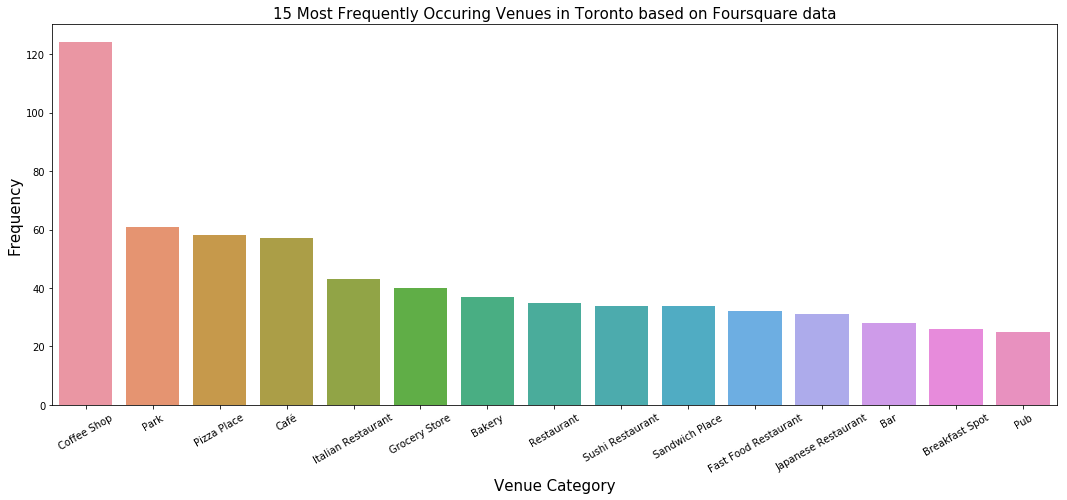

In [41]:
#Top 15 bar of the popular venue categories for the selected city
fig = plt.figure(figsize=(18,7))
s=sns.barplot(x="Venue Category", y="Frequency", data=Toronto_Venues_Top15)
s.set_xticklabels(s.get_xticklabels(), rotation=30)
plt.title('15 Most Frequently Occuring Venues in Toronto based on Foursquare data', fontsize=15)
plt.xlabel("Venue Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)

plt.show()

In [42]:
print(Toronto_venues.shape)
Toronto_venues.head(20)

(1694, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rosedale-Moore Park,43.679563,-79.377529,Summerhill Market,43.686265,-79.375458,Grocery Store
1,Rosedale-Moore Park,43.679563,-79.377529,Toronto Lawn Tennis Club,43.680667,-79.388559,Athletics & Sports
2,Rosedale-Moore Park,43.679563,-79.377529,Black Camel,43.677016,-79.389367,BBQ Joint
3,Rosedale-Moore Park,43.679563,-79.377529,Tinuno,43.671281,-79.374920,Filipino Restaurant
4,Rosedale-Moore Park,43.679563,-79.377529,Maison Selby,43.671232,-79.376618,Bistro
5,Rosedale-Moore Park,43.679563,-79.377529,Craigleigh Gardens,43.678099,-79.371586,Park
6,Rosedale-Moore Park,43.679563,-79.377529,Pie Squared,43.672143,-79.377856,Pie Shop
7,Rosedale-Moore Park,43.679563,-79.377529,Manulife Financial,43.672070,-79.382449,Office
8,Rosedale-Moore Park,43.679563,-79.377529,Starbucks,43.671082,-79.380756,Coffee Shop
9,Rosedale-Moore Park,43.679563,-79.377529,Booster Juice,43.671566,-79.378581,Smoothie Shop


In [43]:
Toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Agincourt North,Milliken",31,31,31,31,31,31
"Annex,Casa Loma",100,100,100,100,100,100
Banbury-Don Mills,29,29,29,29,29,29
Bay Street Corridor,100,100,100,100,100,100
"Bayview Village,Bayview Woods-Steeles",13,13,13,13,13,13
"Bedford Park-Nortown,Lawrence Park North",38,38,38,38,38,38
Birchcliffe-Cliffside,14,14,14,14,14,14
Bridle Path-Sunnybrook-York Mills,18,18,18,18,18,18
Church-Yonge Corridor,100,100,100,100,100,100


In [44]:
print(Toronto_venues.shape)
Toronto_venues[Toronto_venues['Neighborhood']=='St.Andrew-Windfields']

(1694, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
552,St.Andrew-Windfields,43.75749,-79.374714,York Mills Collegiate Institute Swimming Pool,43.750994,-79.374365,Pool
553,St.Andrew-Windfields,43.75749,-79.374714,Talara Park,43.765457,-79.377301,Park
554,St.Andrew-Windfields,43.75749,-79.374714,St. Andrews Park,43.757309,-79.386616,Park
555,St.Andrew-Windfields,43.75749,-79.374714,Ames Park,43.751868,-79.365473,Park


In [45]:
#All Restaurant venues that contain Restaurant or BBQ on their category name
Toronto_restaurants = Toronto_venues[Toronto_venues['Venue Category'].str.contains('Restaurant|BBQ|Bistro|Steakhouse|Noodle|Diner|Poke')].reset_index(drop=True)
print(Toronto_restaurants.shape)
Toronto_restaurants.head()

(456, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rosedale-Moore Park,43.679563,-79.377529,Black Camel,43.677016,-79.389367,BBQ Joint
1,Rosedale-Moore Park,43.679563,-79.377529,Tinuno,43.671281,-79.374920,Filipino Restaurant
2,Rosedale-Moore Park,43.679563,-79.377529,Maison Selby,43.671232,-79.376618,Bistro
3,Rosedale-Moore Park,43.679563,-79.377529,Nijo Japanese Restaurant,43.671849,-79.378824,Japanese Restaurant
4,Bridle Path-Sunnybrook-York Mills,43.752758,-79.400049,Auberge du Pommier,43.746962,-79.407879,French Restaurant


In [46]:
#count number of restaurants for each neighbourhood
TNR_count=Toronto_restaurants.groupby('Neighborhood').agg('count')[['Venue Category']]
TNR_count.rename(columns={"Venue Category": "# Restaurants"}, inplace=True)
TNR_count.reset_index()

,Neighborhood,# Restaurants
0,"Agincourt North,Milliken",15
1,"Annex,Casa Loma",33
2,Banbury-Don Mills,9
3,Bay Street Corridor,25
4,"Bayview Village,Bayview Woods-Steeles",4
5,"Bedford Park-Nortown,Lawrence Park North",12
6,Birchcliffe-Cliffside,4
7,Bridle Path-Sunnybrook-York Mills,3
8,Church-Yonge Corridor,34
9,"Don Valley Village,Henry Farm,Pleasant View",7


In [47]:
# create a dataframe of top 10 restaurants categories
TNR_Top10 = Toronto_restaurants['Venue Category'].value_counts()[0:10].to_frame(name='frequency')
TNR_Top10=TNR_Top10.reset_index()

TNR_Top10.rename(index=str, columns={"index": "Venue Category", "frequency": "Frequency"}, inplace=True)
TNR_Top10


,Venue Category,Frequency
0,Italian Restaurant,43
1,Restaurant,35
2,Sushi Restaurant,34
3,Fast Food Restaurant,32
4,Japanese Restaurant,31
5,Chinese Restaurant,24
6,Thai Restaurant,24
7,Middle Eastern Restaurant,16
8,Vietnamese Restaurant,14
9,Indian Restaurant,14


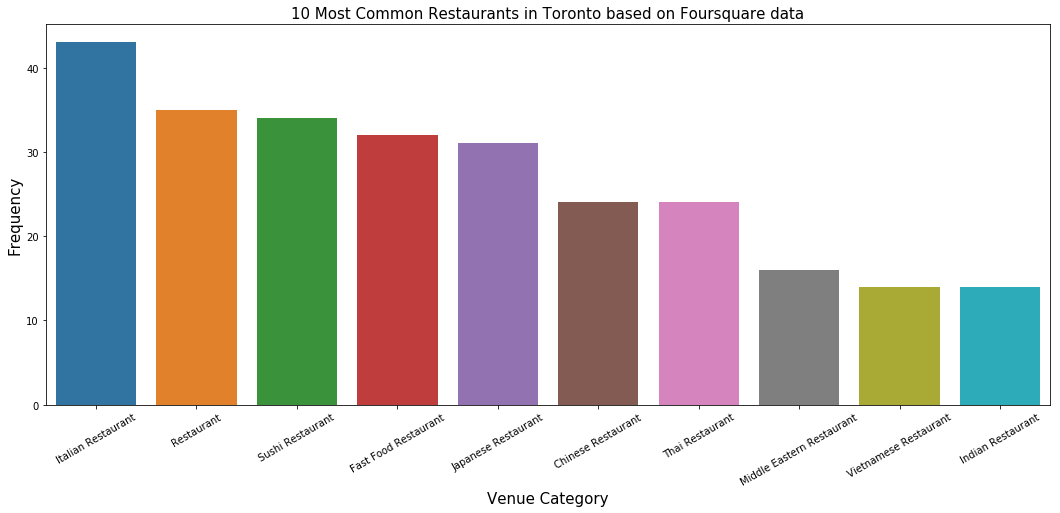

In [48]:

#Top 10 bar of the popular venue categories for the selected city
fig = plt.figure(figsize=(18,7))
s=sns.barplot(x="Venue Category", y="Frequency", data=TNR_Top10)
s.set_xticklabels(s.get_xticklabels(), rotation=30)
plt.title('10 Most Common Restaurants in Toronto based on Foursquare data', fontsize=15)
plt.xlabel("Venue Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)

plt.show()


In [49]:
#Japanese Restaurant venues that contain Sushi or Japanese or Ramen on their category name
Toronto_Japanese_restaurant = Toronto_venues[Toronto_venues['Venue Category'].str.contains('Sushi|Japanese|Ramen')].reset_index(drop=True)
print(Toronto_Japanese_restaurant.shape)
Toronto_Japanese_restaurant

(77, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rosedale-Moore Park,43.679563,-79.377529,Nijo Japanese Restaurant,43.671849,-79.378824,Japanese Restaurant
1,Kingsway South,43.653654,-79.506944,Momiji Sushi Bar & Grill,43.647843,-79.508534,Sushi Restaurant
2,Kingsway South,43.653654,-79.506944,Sushi 2 Go,43.647875,-79.509427,Sushi Restaurant
3,Leaside-Bennington,43.709060,-79.363452,Kintako Japanese Restaurant,43.711597,-79.363962,Sushi Restaurant
4,Leaside-Bennington,43.709060,-79.363452,Nigiri-Ya,43.703218,-79.364279,Japanese Restaurant
5,"Annex,Casa Loma",43.672710,-79.405678,Gyubee,43.667088,-79.400571,Japanese Restaurant
6,"Annex,Casa Loma",43.672710,-79.405678,Sushi On Bloor,43.665505,-79.409296,Sushi Restaurant
7,"Annex,Casa Loma",43.672710,-79.405678,Mr. Tonkatsu 豚カツ,43.665252,-79.410831,Japanese Restaurant
8,South Riverdale,43.659526,-79.340923,Kibo Sushi House,43.662633,-79.332677,Sushi Restaurant
9,South Riverdale,43.659526,-79.340923,Sushi Bar,43.658798,-79.350085,Sushi Restaurant


In [50]:
#count number of japanese restaurants for each neighbourhood
df_JRC=Toronto_Japanese_restaurant.groupby('Neighborhood').agg('count')[['Venue Category']]
df_JRC.rename(columns={"Venue Category": "# Japanese_Restaurants"}, inplace=True)
df_JRC.reset_index(inplace=True)
df_JRC

,Neighborhood,# Japanese_Restaurants
0,"Annex,Casa Loma",3
1,Banbury-Don Mills,3
2,Bay Street Corridor,6
3,"Bayview Village,Bayview Woods-Steeles",2
4,"Bedford Park-Nortown,Lawrence Park North",1
5,Church-Yonge Corridor,8
6,"Don Valley Village,Henry Farm,Pleasant View",2
7,"East End-Danforth,The Beaches",4
8,"Forest Hill South,Yonge-St.Clair",6
9,"High Park North,High Park-Swansea,Junction Area",3


In [51]:
#Return locations with less than 3 Japanese restaurant
TN_JR=Toronto_Japanese_restaurant.groupby('Neighborhood').count()
TN_JR1=TN_JR[TN_JR['Venue Category']<3]
TN_JR1['Venue Category']

Neighborhood
Bayview Village,Bayview Woods-Steeles          2
Bedford Park-Nortown,Lawrence Park North       1
Don Valley Village,Henry Farm,Pleasant View    2
Kingsway South                                 2
Leaside-Bennington                             2
Rosedale-Moore Park                            1
South Riverdale                                2
Name: Venue Category, dtype: int64

In [52]:
#Create the list of business it exclude restaurants and BBQ joints
Toronto_business = Toronto_venues[Toronto_venues['Venue Category'].str.contains('Auto|Bakery|Bank|Bar|Brewery|Building|Business|Breakfast|Taco|Burrito|Butcher|store|Boutique|Coffee|Café|Cafe|Creperie|Club|Chiropractor|Concert|Deli|Entertainment|Athletics|Service|Pharmacy|Hotel|Hostel|Health|Storage|Soup|Snack|Sandwich|Salon|Tea|Grocery|Store|pub|Historic|Gym|Studio|Rock|Shop|Museum|Plaza|Gallery|Pub|Office|Theater|Mall|Market|market|Wings|Gas|Rental|Pizza')].reset_index(drop=True)
print(Toronto_business.shape)
Toronto_business.head()

(1016, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rosedale-Moore Park,43.679563,-79.377529,Summerhill Market,43.686265,-79.375458,Grocery Store
1,Rosedale-Moore Park,43.679563,-79.377529,Toronto Lawn Tennis Club,43.680667,-79.388559,Athletics & Sports
2,Rosedale-Moore Park,43.679563,-79.377529,Pie Squared,43.672143,-79.377856,Pie Shop
3,Rosedale-Moore Park,43.679563,-79.377529,Manulife Financial,43.672070,-79.382449,Office
4,Rosedale-Moore Park,43.679563,-79.377529,Starbucks,43.671082,-79.380756,Coffee Shop


In [53]:
#count number of business for each restaurant
df_BC=Toronto_business.groupby('Neighborhood').agg('count')[['Venue Category']]
df_BC.rename(columns={"Venue Category": "# Business"}, inplace=True)
df_BC.reset_index(inplace=True)
df_BC

,Neighborhood,# Business
0,"Agincourt North,Milliken",13
1,"Annex,Casa Loma",59
2,Banbury-Don Mills,16
3,Bay Street Corridor,63
4,"Bayview Village,Bayview Woods-Steeles",5
5,"Bedford Park-Nortown,Lawrence Park North",23
6,Birchcliffe-Cliffside,7
7,Bridle Path-Sunnybrook-York Mills,9
8,Church-Yonge Corridor,59
9,"Don Valley Village,Henry Farm,Pleasant View",34


In [54]:
#create a list with number of business greater than 10
TNB=df_BC[df_BC['# Business']>10]
TNB['# Business']

0     13
1     59
2     16
3     63
5     23
8     59
9     34
11    57
14    11
15    41
17    64
18    27
19    14
20    57
22    47
24    11
25    58
27    14
28    17
29    60
30    16
31    59
33    16
34    63
36    16
39    15
Name: # Business, dtype: int64

In [55]:
print('There are {} uniques categories.'.format(len(Toronto_venues['Venue Category'].unique())))

There are 253 uniques categories.


In [56]:
df_BJP = pd.merge(df_BC, df_JRC, how='outer', on = 'Neighborhood').fillna(0)
df_BJPR = pd.merge(df_BJP, TNR_count, how='outer', on = 'Neighborhood').fillna(0)
df_BJPR.rename(columns={"Neighborhood": "Neighbourhood"}, inplace=True)

df_DemoVenues= pd.merge( df_PCDGfiltered, df_BJPR,how='outer', on = 'Neighbourhood').fillna(0)
df_DemoVenues['# Business']=df_DemoVenues['# Business'].astype(int)
df_DemoVenues['# Restaurants']=df_DemoVenues['# Restaurants'].astype(int)
df_DemoVenues['# Japanese_Restaurants']=df_DemoVenues['# Japanese_Restaurants'].astype(int)
df_DemoVenues.loc[(df_DemoVenues['# Restaurants'] == 0), '# Restaurants'] = 1

df_DemoVenues['Pop/Rests']=df_DemoVenues['Population']/df_DemoVenues['# Restaurants'].round(1)

df_DemoVenues

,Postcode,Neighbourhood,Population,Area square km,Density,Average Income,# Business,# Japanese_Restaurants,# Restaurants,Pop/Rests
0,M1B,"Malvern,Rouge",90290,45.74,1973,147111.605469,8,0,6,15048.333333
1,M1G,Woburn,53485,12.31,4344,145933.058584,4,0,3,17828.333333
2,M1N,Birchcliffe-Cliffside,22291,5.92,3765,85644.236109,7,0,4,5572.750000
3,M1R,Wexford/Maryvale,27917,10.25,2723,78067.678827,16,0,9,3101.888889
4,M1T,Tam O'Shanter-Sullivan,27446,5.41,5073,110348.666226,16,0,13,2111.230769
5,M1V,"Agincourt North,Milliken",55685,16.80,3314,109972.442372,13,0,15,3712.333333
6,M1W,"L'Amoreaux,Steeles",68616,11.69,5869,108967.181983,14,0,7,9802.285714
7,M2J,"Don Valley Village,Henry Farm,Pleasant View",58592,9.80,5978,70714.648265,34,2,7,8370.285714
8,M2K,"Bayview Village,Bayview Woods-Steeles",34550,9.16,3771,73337.552006,5,2,4,8637.500000
9,M2L,St.Andrew-Windfields,17812,7.33,2430,150633.549340,0,0,1,17812.000000


In [57]:
#df_DemoVenues exclude string neighbourhoods, borough, postal, code
df_DV=df_DemoVenues.drop(['Postcode','Neighbourhood'], axis=1)
df_DV.head()

,Population,Area square km,Density,Average Income,# Business,# Japanese_Restaurants,# Restaurants,Pop/Rests
0,90290,45.74,1973,147111.605469,8,0,6,15048.333333
1,53485,12.31,4344,145933.058584,4,0,3,17828.333333
2,22291,5.92,3765,85644.236109,7,0,4,5572.750000
3,27917,10.25,2723,78067.678827,16,0,9,3101.888889
4,27446,5.41,5073,110348.666226,16,0,13,2111.230769


In [58]:
col=['Population','Density','Area square km','Average Income', '# Business', '# Japanese_Restaurants', '# Restaurants']
df_DV.describe().round(1)

,Population,Area square km,Density,Average Income,# Business,# Japanese_Restaurants,# Restaurants,Pop/Rests
count,41.0,41.0,41.0,41.0,41.0,41.0,41.0,41.0
mean,36946.1,9.5,5471.2,128585.8,24.8,1.9,11.2,11132.4
std,19442.1,8.9,3942.9,62796.5,22.4,3.0,11.6,13456.8
min,9266.0,1.4,1039.0,70146.1,0.0,0.0,1.0,651.0
25%,22291.0,4.7,3135.0,85765.3,8.0,0.0,2.0,2111.2
50%,31180.0,7.4,4499.0,109972.4,15.0,0.0,7.0,5230.8
75%,53297.0,10.0,6425.0,150633.5,47.0,3.0,16.0,15179.0
max,90290.0,45.7,23044.0,327842.4,64.0,14.0,38.0,53297.0


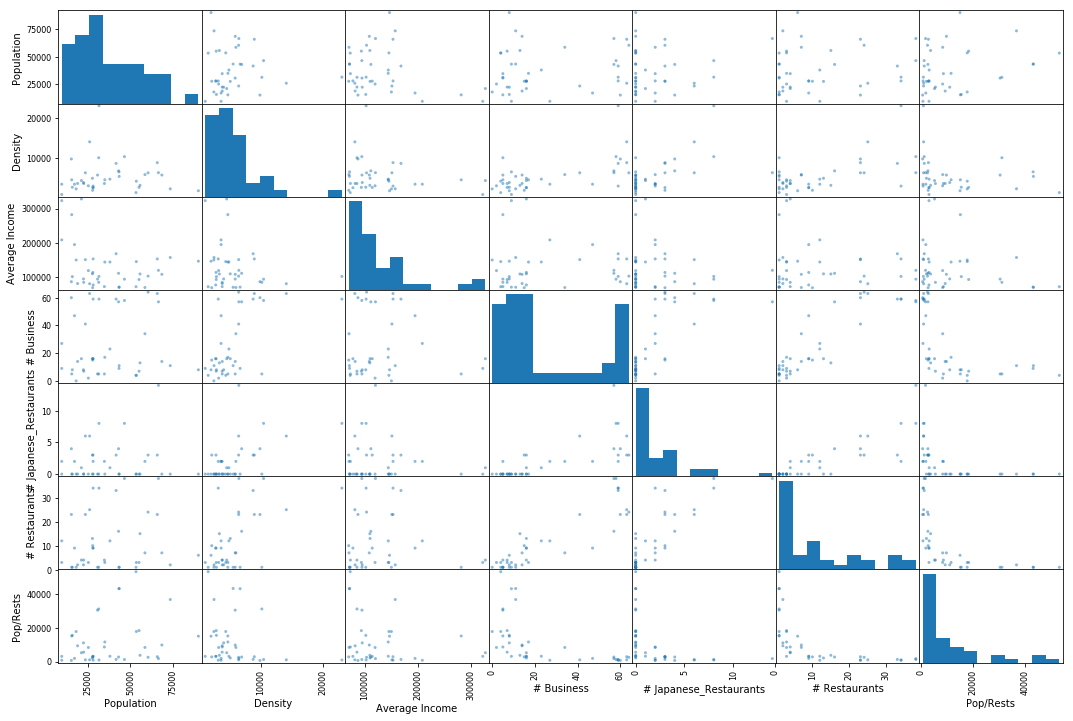

In [59]:

df_DVp=df_DV[['Population','Density','Average Income', '# Business', '# Japanese_Restaurants', '# Restaurants','Pop/Rests']]
scatter_matrix(df_DVp,figsize=(18,12))
#sns.pairplot(df_DVp, figsize=(18,12))
plt.show()


In [60]:
df_DV.corr(method='pearson')

,Population,Area square km,Density,Average Income,# Business,# Japanese_Restaurants,# Restaurants,Pop/Rests
Population,1.000000,0.679820,0.008826,-0.262792,0.098804,0.112169,0.139677,0.254696
Area square km,0.679820,1.000000,-0.432587,-0.081930,-0.319636,-0.243765,-0.242471,0.417785
Density,0.008826,-0.432587,1.000000,-0.201330,0.601904,0.564371,0.580743,-0.198026
Average Income,-0.262792,-0.081930,-0.201330,1.000000,-0.030255,-0.097367,-0.059637,-0.226722
# Business,0.098804,-0.319636,0.601904,-0.030255,1.000000,0.737431,0.892281,-0.544927
# Japanese_Restaurants,0.112169,-0.243765,0.564371,-0.097367,0.737431,1.000000,0.820746,-0.441366
# Restaurants,0.139677,-0.242471,0.580743,-0.059637,0.892281,0.820746,1.000000,-0.577223
Pop/Rests,0.254696,0.417785,-0.198026,-0.226722,-0.544927,-0.441366,-0.577223,1.000000


In [61]:
df_DVC=df_DV.drop(['# Japanese_Restaurants','Density', '# Restaurants', 'Area square km'], axis=1)
df_DV.corr(method='pearson')

,Population,Area square km,Density,Average Income,# Business,# Japanese_Restaurants,# Restaurants,Pop/Rests
Population,1.000000,0.679820,0.008826,-0.262792,0.098804,0.112169,0.139677,0.254696
Area square km,0.679820,1.000000,-0.432587,-0.081930,-0.319636,-0.243765,-0.242471,0.417785
Density,0.008826,-0.432587,1.000000,-0.201330,0.601904,0.564371,0.580743,-0.198026
Average Income,-0.262792,-0.081930,-0.201330,1.000000,-0.030255,-0.097367,-0.059637,-0.226722
# Business,0.098804,-0.319636,0.601904,-0.030255,1.000000,0.737431,0.892281,-0.544927
# Japanese_Restaurants,0.112169,-0.243765,0.564371,-0.097367,0.737431,1.000000,0.820746,-0.441366
# Restaurants,0.139677,-0.242471,0.580743,-0.059637,0.892281,0.820746,1.000000,-0.577223
Pop/Rests,0.254696,0.417785,-0.198026,-0.226722,-0.544927,-0.441366,-0.577223,1.000000


In [62]:
df_DVC['Population']=df_DVC['Population'].astype(float)
df_DVC['Average Income']=df_DVC['Average Income'].astype(float)
df_DVC['# Business']=df_DVC['# Business'].astype(float)
df_std = StandardScaler().fit_transform(df_DVC.values)
df_std = pd.DataFrame(df_std, columns=df_DVC.columns)

df_std

,Population,Average Income,# Business,Pop/Rests
0,2.777820,0.298677,-0.759863,0.294613
1,0.861244,0.279677,-0.940994,0.503766
2,-0.763147,-0.692316,-0.805146,-0.418280
3,-0.470179,-0.814467,-0.397603,-0.604175
4,-0.494706,-0.294025,-0.397603,-0.678707
5,0.975806,-0.300090,-0.533451,-0.558248
6,1.649172,-0.316297,-0.488168,-0.100072
7,1.127184,-0.933015,0.417483,-0.207808
8,-0.124774,-0.890728,-0.895711,-0.187704
9,-0.996385,0.355459,-1.122124,0.502537


In [63]:
df_std.corr(method='pearson')

,Population,Average Income,# Business,Pop/Rests
Population,1.000000,-0.262792,0.098804,0.254696
Average Income,-0.262792,1.000000,-0.030255,-0.226722
# Business,0.098804,-0.030255,1.000000,-0.544927
Pop/Rests,0.254696,-0.226722,-0.544927,1.000000


In [64]:
df_DemoVenues.head()

,Postcode,Neighbourhood,Population,Area square km,Density,Average Income,# Business,# Japanese_Restaurants,# Restaurants,Pop/Rests
0,M1B,"Malvern,Rouge",90290,45.74,1973,147111.605469,8,0,6,15048.333333
1,M1G,Woburn,53485,12.31,4344,145933.058584,4,0,3,17828.333333
2,M1N,Birchcliffe-Cliffside,22291,5.92,3765,85644.236109,7,0,4,5572.750000
3,M1R,Wexford/Maryvale,27917,10.25,2723,78067.678827,16,0,9,3101.888889
4,M1T,Tam O'Shanter-Sullivan,27446,5.41,5073,110348.666226,16,0,13,2111.230769


In [65]:
# set number of clusters
kclusters = 9

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, max_iter=600, n_init=20).fit(df_std)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 6, 0, 0, 0, 6, 6, 6, 0, 0], dtype=int32)

In [66]:
# add clustering labels
df_DemoVenues.insert(0, 'Cluster Labels', kmeans.labels_)

#Toronto_merged = df_TNCoords

# merge toronto venues, demographic and latitude/longitude for each neighborhood
Toronto_merged = pd.merge(df_DemoVenues, df_TNCoords, how='outer',on='Postcode')
Toronto_merged.set_index('Neighbourhood')
Toronto_merged=Toronto_merged.dropna()

In [67]:
Toronto_merged['Cluster Labels']=Toronto_merged['Cluster Labels'].astype(int)

In [68]:
#create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighbourhood'], Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [69]:
print(rainbow)


['#8000ff', '#4062fa', '#00b5eb', '#40ecd4', '#80ffb4', '#c0eb8d', '#ffb360', '#ff5f30', '#ff0000']


In [70]:
df_TM=Toronto_merged.sort_values('Cluster Labels').reset_index(drop=True)
df_TM

,Cluster Labels,Postcode,Neighbourhood,Population,Area square km,Density,Average Income,# Business,# Japanese_Restaurants,# Restaurants,Pop/Rests,Latitude,Longitude
0,0,M1N,Birchcliffe-Cliffside,22291.0,5.92,3765.0,85644.236109,7.0,0.0,4.0,5572.750000,43.692657,-79.264848
1,0,M1R,Wexford/Maryvale,27917.0,10.25,2723.0,78067.678827,16.0,0.0,9.0,3101.888889,43.750072,-79.295849
2,0,M1T,Tam O'Shanter-Sullivan,27446.0,5.41,5073.0,110348.666226,16.0,0.0,13.0,2111.230769,43.781638,-79.304302
3,0,M5M,"Bedford Park-Nortown,Lawrence Park North",37843.0,7.80,4851.0,144760.952290,23.0,1.0,12.0,3153.583333,43.733283,-79.419750
4,0,M8Y,Stonegate-Queensway,25051.0,7.83,3199.0,119843.838510,2.0,0.0,3.0,8350.333333,43.636258,-79.498509
5,0,M4B,O'Connor-Parkview,18675.0,4.94,3780.0,82248.728351,14.0,0.0,2.0,9337.500000,43.706397,-79.309937
6,0,M2K,"Bayview Village,Bayview Woods-Steeles",34550.0,9.16,3771.0,73337.552006,5.0,2.0,4.0,8637.500000,43.786947,-79.385975
7,0,M2L,St.Andrew-Windfields,17812.0,7.33,2430.0,150633.549340,0.0,0.0,1.0,17812.000000,43.757490,-79.374714
8,0,M9A,Edenbridge-Humber Valley,15535.0,5.47,2840.0,102322.730799,8.0,0.0,1.0,15535.000000,43.667856,-79.532242
9,0,M9P,Willowridge-Martingrove-Richview,22156.0,5.53,4006.0,95652.817704,8.0,0.0,2.0,11078.000000,43.696319,-79.532242


In [71]:
df_TM1=df_TM[(df_TM['# Business']>20) & (df_TM['Pop/Rests']>2000)  & (df_TM['# Restaurants']<=25)]
df_TM1.reset_index(drop=True, inplace=True)

df_TM1.drop(['Postcode','Latitude','Longitude'], axis=1)


,Cluster Labels,Neighbourhood,Population,Area square km,Density,Average Income,# Business,# Japanese_Restaurants,# Restaurants,Pop/Rests
0,0,"Bedford Park-Nortown,Lawrence Park North",37843.0,7.80,4851.0,144760.952290,23.0,1.0,12.0,3153.583333
1,2,"East End-Danforth,The Beaches",42948.0,6.22,6904.0,111908.408449,57.0,4.0,16.0,2684.250000
2,2,Waterfront Communities-The Island,65913.0,7.37,8943.0,153659.253917,63.0,3.0,23.0,2865.782609
3,2,"High Park North,High Park-Swansea,Junction Area",60453.0,9.42,6417.0,103786.907376,64.0,3.0,24.0,2518.875000
4,6,"Don Valley Village,Henry Farm,Pleasant View",58592.0,9.80,5978.0,70714.648265,34.0,2.0,7.0,8370.285714


In [72]:
df_TM2=df_TM[(df_TM['# Restaurants']>25)&(df_TM['# Business']>40)]
df_TM2.reset_index(drop=True, inplace=True)
df_TM2.drop(['Postcode','Latitude','Longitude'], axis=1)

,Cluster Labels,Neighbourhood,Population,Area square km,Density,Average Income,# Business,# Japanese_Restaurants,# Restaurants,Pop/Rests
0,2,"Lansing-Westgate,Willowdale East",66598.0,10.32,6453.0,120573.847727,57.0,14.0,38.0,1752.578947
1,2,"Annex,Casa Loma",41494.0,4.74,8754.0,168702.046410,59.0,3.0,33.0,1257.393939
2,2,"Mount Pleasant East,Mount Pleasant West",46433.0,4.45,10434.0,94849.188904,58.0,8.0,38.0,1221.921053
3,7,South Riverdale,27876.0,8.89,3135.0,153733.028955,59.0,2.0,34.0,819.882353
4,7,Church-Yonge Corridor,31340.0,1.36,23044.0,102944.946692,59.0,8.0,34.0,921.764706


In [74]:
Toronto_mergedd=Toronto_merged.drop(['Postcode','Latitude','Longitude','Average Income'], axis=1)
cluster0=Toronto_mergedd.loc[Toronto_mergedd['Cluster Labels'] == 0]
cluster0.reset_index(drop=True, inplace=True)
cluster0

,Cluster Labels,Neighbourhood,Population,Area square km,Density,# Business,# Japanese_Restaurants,# Restaurants,Pop/Rests
0,0,Birchcliffe-Cliffside,22291.0,5.92,3765.0,7.0,0.0,4.0,5572.750000
1,0,Wexford/Maryvale,27917.0,10.25,2723.0,16.0,0.0,9.0,3101.888889
2,0,Tam O'Shanter-Sullivan,27446.0,5.41,5073.0,16.0,0.0,13.0,2111.230769
3,0,"Bayview Village,Bayview Woods-Steeles",34550.0,9.16,3771.0,5.0,2.0,4.0,8637.500000
4,0,St.Andrew-Windfields,17812.0,7.33,2430.0,0.0,0.0,1.0,17812.000000
5,0,Parkwoods-Donalda,34805.0,7.42,4690.0,17.0,0.0,3.0,11601.666667
6,0,Banbury-Don Mills,27695.0,9.98,2775.0,16.0,3.0,9.0,3077.222222
7,0,York University Heights,27593.0,13.23,2085.0,15.0,3.0,10.0,2759.300000
8,0,O'Connor-Parkview,18675.0,4.94,3780.0,14.0,0.0,2.0,9337.500000
9,0,"Bedford Park-Nortown,Lawrence Park North",37843.0,7.80,4851.0,23.0,1.0,12.0,3153.583333


In [75]:
cluster1=Toronto_mergedd.loc[Toronto_mergedd['Cluster Labels'] == 1]
cluster1.reset_index(drop=True, inplace=True)
cluster1

,Cluster Labels,Neighbourhood,Population,Area square km,Density,# Business,# Japanese_Restaurants,# Restaurants,Pop/Rests
0,1,"Malvern,Rouge",90290.0,45.74,1973.0,8.0,0.0,6.0,15048.333333
1,1,"Eringate-Centennial-West Deane,Islington-City ...",73604.0,29.94,2458.0,11.0,0.0,2.0,36802.000000


In [76]:
cluster2=Toronto_mergedd.loc[Toronto_mergedd['Cluster Labels'] == 2]
cluster2.reset_index(drop=True, inplace=True)
cluster2

,Cluster Labels,Neighbourhood,Population,Area square km,Density,# Business,# Japanese_Restaurants,# Restaurants,Pop/Rests
0,2,"Lansing-Westgate,Willowdale East",66598.0,10.32,6453.0,57.0,14.0,38.0,1752.578947
1,2,"East End-Danforth,The Beaches",42948.0,6.22,6904.0,57.0,4.0,16.0,2684.250000
2,2,"Mount Pleasant East,Mount Pleasant West",46433.0,4.45,10434.0,58.0,8.0,38.0,1221.921053
3,2,Waterfront Communities-The Island,65913.0,7.37,8943.0,63.0,3.0,23.0,2865.782609
4,2,"Annex,Casa Loma",41494.0,4.74,8754.0,59.0,3.0,33.0,1257.393939
5,2,"High Park North,High Park-Swansea,Junction Area",60453.0,9.42,6417.0,64.0,3.0,24.0,2518.875000


In [77]:
cluster3=Toronto_mergedd.loc[Toronto_mergedd['Cluster Labels'] == 3]
cluster3.reset_index(drop=True, inplace=True)
cluster3

,Cluster Labels,Neighbourhood,Population,Area square km,Density,# Business,# Japanese_Restaurants,# Restaurants,Pop/Rests
0,3,Leaside-Bennington,16828.0,4.68,3595.0,47.0,2.0,9.0,1869.777778
1,3,"Forest Hill South,Yonge-St.Clair",23260.0,3.62,6425.0,41.0,6.0,23.0,1011.304348
2,3,Kingsway South,9271.0,2.58,3593.0,27.0,2.0,12.0,772.583333


In [78]:
cluster4=Toronto_mergedd.loc[Toronto_mergedd['Cluster Labels'] == 4]
cluster4.reset_index(drop=True, inplace=True)
cluster4

,Cluster Labels,Neighbourhood,Population,Area square km,Density,# Business,# Japanese_Restaurants,# Restaurants,Pop/Rests
0,4,Bridle Path-Sunnybrook-York Mills,9266.0,8.91,1039.0,9.0,0.0,3.0,3088.666667
1,4,Lawrence Park South,15179.0,3.24,4684.0,5.0,0.0,1.0,15179.000000
2,4,Rosedale-Moore Park,20923.0,4.65,4499.0,16.0,1.0,4.0,5230.750000


In [79]:
cluster5=Toronto_mergedd.loc[Toronto_mergedd['Cluster Labels'] == 5]
cluster5.reset_index(drop=True, inplace=True)
cluster5

,Cluster Labels,Neighbourhood,Population,Area square km,Density,# Business,# Japanese_Restaurants,# Restaurants,Pop/Rests
0,5,Glenfield-Jane Heights,30491.0,5.20,5863.0,5.0,0.0,1.0,30491.0
1,5,Niagara,31180.0,3.07,10156.0,5.0,0.0,1.0,31180.0


In [80]:
cluster6=Toronto_mergedd.loc[Toronto_mergedd['Cluster Labels'] == 6]
cluster6.reset_index(drop=True, inplace=True)
cluster6

,Cluster Labels,Neighbourhood,Population,Area square km,Density,# Business,# Japanese_Restaurants,# Restaurants,Pop/Rests
0,6,Woburn,53485.0,12.31,4344.0,4.0,0.0,3.0,17828.333333
1,6,"Agincourt North,Milliken",55685.0,16.80,3314.0,13.0,0.0,15.0,3712.333333
2,6,"L'Amoreaux,Steeles",68616.0,11.69,5869.0,14.0,0.0,7.0,9802.285714
3,6,"Don Valley Village,Henry Farm,Pleasant View",58592.0,9.80,5978.0,34.0,2.0,7.0,8370.285714
4,6,"Downsview-Roding-CFB,Maple Leaf,Rustic",55104.0,19.62,2808.0,7.0,0.0,3.0,18368.000000


In [81]:
cluster7=Toronto_mergedd.loc[Toronto_mergedd['Cluster Labels'] == 7]
cluster7.reset_index(drop=True, inplace=True)
cluster7

,Cluster Labels,Neighbourhood,Population,Area square km,Density,# Business,# Japanese_Restaurants,# Restaurants,Pop/Rests
0,7,South Riverdale,27876.0,8.89,3135.0,59.0,2.0,34.0,819.882353
1,7,Church-Yonge Corridor,31340.0,1.36,23044.0,59.0,8.0,34.0,921.764706
2,7,Bay Street Corridor,25797.0,1.83,14096.0,63.0,6.0,25.0,1031.880000
3,7,Roncesvalles,14974.0,1.52,9851.0,60.0,4.0,23.0,651.043478


In [82]:
cluster8=Toronto_mergedd.loc[Toronto_mergedd['Cluster Labels'] == 8]
cluster8.reset_index(drop=True, inplace=True)
cluster8

,Cluster Labels,Neighbourhood,Population,Area square km,Density,# Business,# Japanese_Restaurants,# Restaurants,Pop/Rests
0,8,"Westminster-Branson,Willowdale West",43210.0,6.49,6657.0,9.0,0.0,1.0,43210.0
1,8,"Mount Olive-Silverstone-Jamestown,Thistletown-...",43314.0,7.83,5531.0,11.0,0.0,1.0,43314.0
2,8,"Elms-Old Rexdale,Rexdale-Kipling,West Humber-C...",53297.0,35.16,1515.0,4.0,0.0,1.0,53297.0


In [83]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Neighborhood'] = Toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_onehot.head()

,Zoo,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Stadium,Beach,Beer Bar,Beer Store,Bike Shop,Bistro,Bookstore,Boutique,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Quad,College Stadium,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Drugstore,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewish Restaurant,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Liquor Store,Lounge,Malay Restaurant,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,Nightclub,Noodle House,Office,Opera House,Organic Grocery,Other Great Outdoors,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pide Place,Pie Shop,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Road,Rock Climbing Spot,Rock Club,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shop & Service,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stationery Store,Steakhouse,Storage Facility,Supermarket,Sushi Restaurant,Syrian Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Track,Trail,Train Station,Udon Restaurant,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Rosedale-Moore Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [84]:
Toronto_onehot.shape

(1694, 253)

In [85]:
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()
Toronto_grouped.head()

,Neighborhood,Zoo,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Stadium,Beach,Beer Bar,Beer Store,Bike Shop,Bistro,Bookstore,Boutique,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Quad,College Stadium,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Drugstore,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewish Restaurant,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Liquor Store,Lounge,Malay Restaurant,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,Nightclub,Noodle House,Office,Opera House,Organic Grocery,Other Great Outdoors,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pide Place,Pie Shop,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Road,Rock Climbing Spot,Rock Club,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shop & Service,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stationery Store,Steakhouse,Storage Facility,Supermarket,Sushi Restaurant,Syrian Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Track,Trail,Train Station,Udon Restaurant,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Agincourt North,Milliken",0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.000000,0.0,0.0,0.0,0.032258,0.0,0.0,0.0,0.064516,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.032258,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.032258,0.00,0.0,0.0,0.161290,0.0,0.0,0.0,0.0,0.00,0.0,0.032258,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.032258,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.032258,0.

In [86]:
Toronto_grouped.shape

(41, 253)

Print the top 10 most common venues for each selected neighbourhood based on their popularity

In [87]:
num_top_venues = 10
for hood in Toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Toronto_grouped[Toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt North,Milliken----
                  venue  freq
0    Chinese Restaurant  0.16
1                  Park  0.06
2           Pizza Place  0.06
3          Noodle House  0.06
4                Bakery  0.06
5  Fast Food Restaurant  0.06
6     Korean Restaurant  0.03
7      Malay Restaurant  0.03
8           Coffee Shop  0.03
9         Grocery Store  0.03


----Annex,Casa Loma----
                           venue  freq
0                           Café  0.06
1  Vegetarian / Vegan Restaurant  0.05
2             Italian Restaurant  0.04
3                         Bakery  0.04
4                            Pub  0.04
5                     Restaurant  0.03
6                    Coffee Shop  0.03
7                            Gym  0.03
8                  Grocery Store  0.03
9                         Museum  0.03


----Banbury-Don Mills----
                 venue  freq
0  Japanese Restaurant  0.10
1         Burger Joint  0.07
2          Pizza Place  0.07
3          Coffee Shop  0.07
4        

In [88]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [89]:
num_top_venues = 4

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Toronto_grouped['Neighborhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
0,"Agincourt North,Milliken",Chinese Restaurant,Bakery,Pizza Place,Park
1,"Annex,Casa Loma",Café,Vegetarian / Vegan Restaurant,Pub,Bakery
2,Banbury-Don Mills,Japanese Restaurant,Burger Joint,Pizza Place,Coffee Shop
3,Bay Street Corridor,Coffee Shop,Café,Ice Cream Shop,Italian Restaurant
4,"Bayview Village,Bayview Woods-Steeles",Japanese Restaurant,Bank,Grocery Store,Park


In [90]:
# set number of clusters
kclusters1 = 3

Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans1 = KMeans(n_clusters=kclusters1, random_state=0).fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans1.labels_[0:5] 

array([0, 0, 0, 0, 0], dtype=int32)

In [91]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans1.labels_)

Toronto_merged1 = df_LocationDG

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Toronto_merged1 = Toronto_merged1.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

Toronto_merged1=Toronto_merged1.dropna() 

In [92]:
Toronto_merged1['Cluster Labels']=Toronto_merged1['Cluster Labels'].astype(int)

In [93]:
 #create map
map_clusters1 = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x1 = np.arange(kclusters)
ys1 = [i + x + (i*x1)**2 for i in range(kclusters1)]
colors_array1 = cm.rainbow(np.linspace(0, 1, len(ys1)))
rainbow1 = [colors.rgb2hex(i) for i in colors_array1]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged1['Latitude'], Toronto_merged1['Longitude'], Toronto_merged1['Neighbourhood'], Toronto_merged1['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow1[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters1)
       
map_clusters1

In [94]:
Toronto_merged1.sort_values('Cluster Labels').reset_index(drop=True)
Toronto_merged1

,Postcode,Neighbourhood,Population,Area square km,Density,Average Income,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
0,M4W,Rosedale-Moore Park,20923,4.65,4499,327842.352420,43.679563,-79.377529,0,Coffee Shop,Grocery Store,Park,Filipino Restaurant
1,M2P,Bridle Path-Sunnybrook-York Mills,9266,8.91,1039,322942.112267,43.752758,-79.400049,0,Park,Coffee Shop,Restaurant,French Restaurant
2,M4N,Lawrence Park South,15179,3.24,4684,282244.042538,43.728020,-79.388790,0,Bookstore,College Quad,Gym / Fitness Center,College Gym
3,M8X,Kingsway South,9271,2.58,3593,208942.045617,43.653654,-79.506944,0,Coffee Shop,Park,Smoke Shop,Sushi Restaurant
4,M4G,Leaside-Bennington,16828,4.68,3595,195253.063975,43.709060,-79.363452,0,Coffee Shop,Sporting Goods Shop,Furniture / Home Store,Grocery Store
5,M5R,"Annex,Casa Loma",41494,4.74,8754,168702.046410,43.672710,-79.405678,0,Café,Vegetarian / Vegan Restaurant,Pub,Bakery
6,M9B,"Eringate-Centennial-West Deane,Islington-City ...",73604,29.94,2458,157834.625128,43.650943,-79.554724,0,Park,Hotel,Pizza Place,Fish & Chips Shop
7,M4M,South Riverdale,27876,8.89,3135,153733.028955,43.659526,-79.340923,0,Coffee Shop,Café,Bar,Vietnamese Restaurant
8,M5E,Waterfront Communities-The Island,65913,7.37,8943,153659.253917,43.644771,-79.373306,0,Coffee Shop,Café,Hotel,Beer Bar
9,M4V,"Forest Hill South,Yonge-St.Clair",23260,3.62,6425,151617.671899,43.686412,-79.400049,0,Coffee Shop,Sushi Restaurant,Park,Italian Restaurant


Cluster 0 Information

In [95]:
df_cluster0=Toronto_merged1.loc[Toronto_merged1['Cluster Labels'] == 0]
df_cluster0.reset_index(drop=True, inplace=True)
df_cluster0

,Postcode,Neighbourhood,Population,Area square km,Density,Average Income,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
0,M4W,Rosedale-Moore Park,20923,4.65,4499,327842.352420,43.679563,-79.377529,0,Coffee Shop,Grocery Store,Park,Filipino Restaurant
1,M2P,Bridle Path-Sunnybrook-York Mills,9266,8.91,1039,322942.112267,43.752758,-79.400049,0,Park,Coffee Shop,Restaurant,French Restaurant
2,M4N,Lawrence Park South,15179,3.24,4684,282244.042538,43.728020,-79.388790,0,Bookstore,College Quad,Gym / Fitness Center,College Gym
3,M8X,Kingsway South,9271,2.58,3593,208942.045617,43.653654,-79.506944,0,Coffee Shop,Park,Smoke Shop,Sushi Restaurant
4,M4G,Leaside-Bennington,16828,4.68,3595,195253.063975,43.709060,-79.363452,0,Coffee Shop,Sporting Goods Shop,Furniture / Home Store,Grocery Store
5,M5R,"Annex,Casa Loma",41494,4.74,8754,168702.046410,43.672710,-79.405678,0,Café,Vegetarian / Vegan Restaurant,Pub,Bakery
6,M9B,"Eringate-Centennial-West Deane,Islington-City ...",73604,29.94,2458,157834.625128,43.650943,-79.554724,0,Park,Hotel,Pizza Place,Fish & Chips Shop
7,M4M,South Riverdale,27876,8.89,3135,153733.028955,43.659526,-79.340923,0,Coffee Shop,Café,Bar,Vietnamese Restaurant
8,M5E,Waterfront Communities-The Island,65913,7.37,8943,153659.253917,43.644771,-79.373306,0,Coffee Shop,Café,Hotel,Beer Bar
9,M4V,"Forest Hill South,Yonge-St.Clair",23260,3.62,6425,151617.671899,43.686412,-79.400049,0,Coffee Shop,Sushi Restaurant,Park,Italian Restaurant


Cluster 1 Information

In [96]:
df_cluster1 = Toronto_merged1.loc[Toronto_merged1['Cluster Labels'] == 1]
df_cluster1.reset_index(drop=True, inplace=True)
df_cluster1

,Postcode,Neighbourhood,Population,Area square km,Density,Average Income,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
0,M8Y,Stonegate-Queensway,25051,7.83,3199,119843.83851,43.636258,-79.498509,1,Italian Restaurant,Park,Shopping Mall,Ice Cream Shop


Cluster 2 Information

In [97]:
df_cluster2=Toronto_merged1.loc[Toronto_merged1['Cluster Labels'] == 2]
df_cluster2.reset_index(drop=True, inplace=True)
df_cluster2

,Postcode,Neighbourhood,Population,Area square km,Density,Average Income,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
0,M2L,St.Andrew-Windfields,17812,7.33,2430,150633.54934,43.75749,-79.374714,2,Park,Pool,Design Studio,Farmers Market
